In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import all CSVs
sales_train_df = pd.read_csv("./dataset/sales_train.csv")
item_cat_df = pd.read_csv("./dataset/item_categories.csv")
item_df = pd.read_csv("./dataset/items.csv")
shops_df = pd.read_csv("./dataset/shops.csv")
test_df = pd.read_csv("./dataset/test.csv")

In [4]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_train_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [6]:
# Convert date object to datetime format
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format='%d.%m.%Y')

In [ ]:
monthly_sales_df = sales_train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'date': ['min', 'max'], 'item_price': 'mean', 'item_cnt_day': 'sum'})

In [10]:
# example usage groupby
#df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})
monthly_sales_df = sales_train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'date': ['min', 'max'], 'item_price': 'mean', 'item_cnt_day': 'sum'})

In [12]:
monthly_sales_df.tail()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

In [13]:
sales_train_df['revenue'] = sales_train_df['item_price']*sales_train_df['item_cnt_day']

In [18]:
# Check missing values
sales_train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
revenue           0
dtype: int64

In [14]:
monthly_sales_shop_df = sales_train_df.groupby(['date_block_num', 'shop_id']).agg(
    {'revenue': 'sum'})

In [53]:
temp = monthly_sales_shop_df.loc[(slice(0,33), 42), 'revenue']

In [54]:
temp.index.get_level_values('date_block_num')

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33],
           dtype='int64', name='date_block_num')

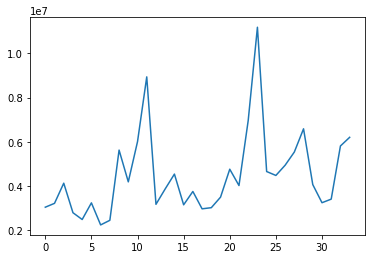

In [55]:
# plot sales by store 42
plt.plot(temp.index.get_level_values('date_block_num'), temp.values)

In [56]:
monthly_sales_total_df = sales_train_df.groupby(['date_block_num']).agg(
    {'revenue': 'sum'})

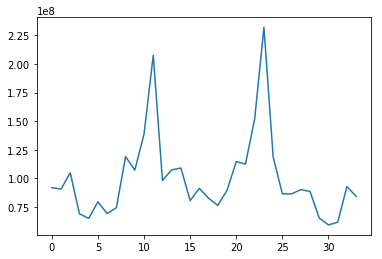

In [57]:
# plot sales for all stores aggregated
plt.plot(monthly_sales_total_df)

In [65]:
# look at items and categories for items
item_count_df = item_df.groupby(['item_category_id'])['item_id'].count()

In [81]:
item_count_df = item_count_df.sort_values()
item_count_df

item_category_id
79       1
10       1
51       1
1        2
50       2
53       3
52       3
26       3
0        4
35       4
48       5
32       6
36       6
18       6
13       6
71       6
80       6
17       7
39       7
81       7
82       8
74       8
34       8
27       8
8        9
46      12
42      12
9       12
83      15
4       15
      ... 
20     175
66     178
45     195
77     220
70     228
28     240
75     277
78     278
64     290
59     294
62     295
38     310
69     317
41     332
76     333
63     366
67     394
56     397
57     427
43     471
23     501
61     598
19     628
72     666
30     756
58     790
31    1125
37    1780
55    2365
40    5035
Name: item_id, Length: 84, dtype: int64

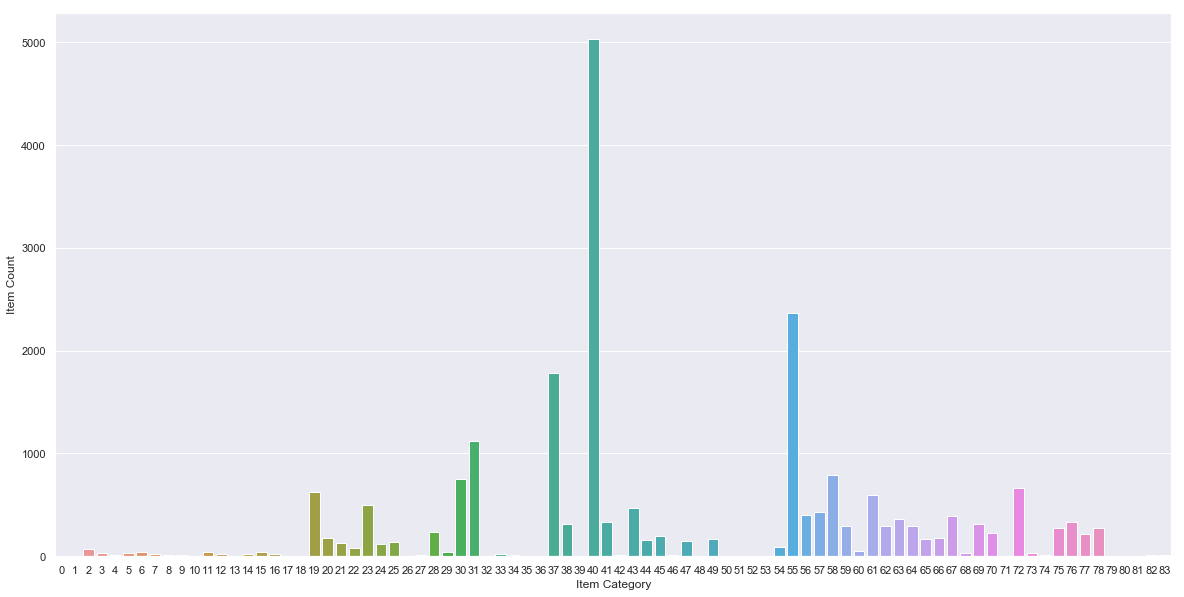

In [95]:
# plot item category and count 
plt.figure(figsize=(20,10))
sns.barplot(item_count_df.index, item_count_df.values)
plt.ylabel('Item Count', fontsize=12)
plt.xlabel('Item Category', fontsize=12)
plt.show()

In [96]:
item_count_df.index

Int64Index([79, 10, 51,  1, 50, 53, 52, 26,  0, 35, 48, 32, 36, 18, 13, 71, 80,
            17, 39, 81, 82, 74, 34, 27,  8, 46, 42,  9, 83,  4, 14, 33, 12, 16,
             7, 68,  5,  3, 73, 15,  6, 11, 29, 60,  2, 22, 54, 24, 21, 25, 47,
            44, 65, 49, 20, 66, 45, 77, 70, 28, 75, 78, 64, 59, 62, 38, 69, 41,
            76, 63, 67, 56, 57, 43, 23, 61, 19, 72, 30, 58, 31, 37, 55, 40],
           dtype='int64', name='item_category_id')

In [74]:
item_count_df.agg(['min', 'max'])

min       1
max    5035
Name: item_id, dtype: int64

In [107]:
item_count_sorted_df = item_count_df.reset_index()

In [121]:
#item_count_sorted_df.values[:,0]
item_count_sorted_df['item_id'].values
item_count_sorted_df.head()

,item_category_id,item_id
0,79,1
1,10,1
2,51,1
3,1,2
4,50,2


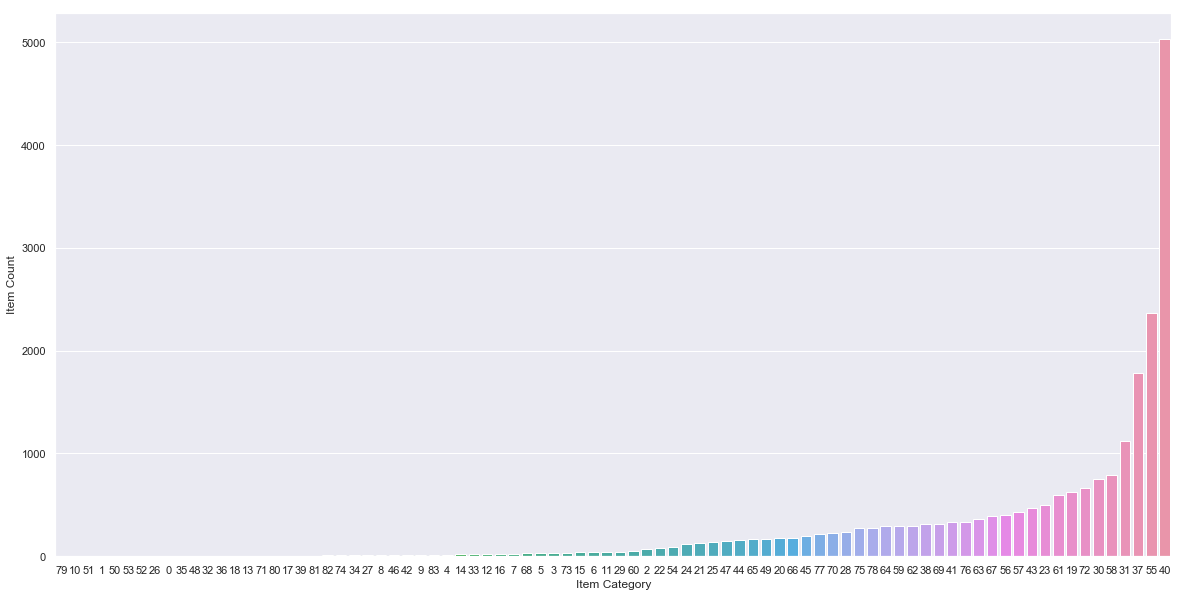

In [124]:
# plot item category and count but order ascending
plt.figure(figsize=(20,10))
#sns.barplot(item_count_sorted_df['item_category_id'], item_count_sorted_df['item_id'], order=item_count_sorted_df['item_id'])
sns.barplot(x=item_count_sorted_df['item_category_id'].values, y=item_count_sorted_df['item_id'].values, order=item_count_sorted_df['item_category_id'].values)
plt.ylabel('Item Count', fontsize=12)
plt.xlabel('Item Category', fontsize=12)
plt.show()

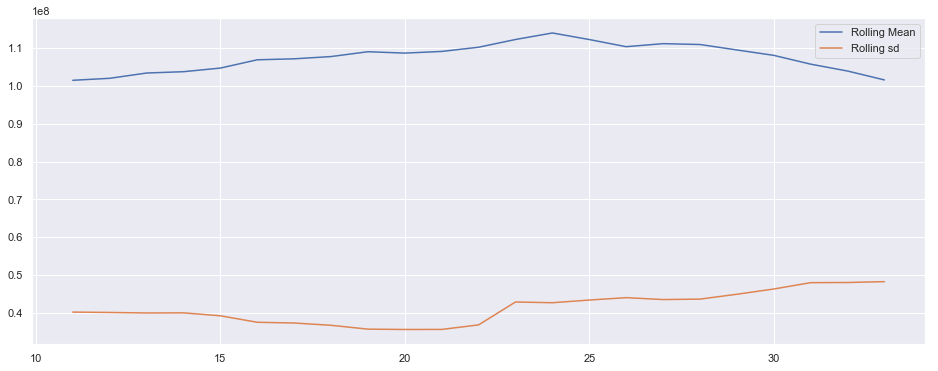

In [127]:
plt.figure(figsize=(16,6))
plt.plot(monthly_sales_total_df.rolling(window=12, center=False).mean(),label='Rolling Mean');
plt.plot(monthly_sales_total_df.rolling(window=12, center=False).std(),label='Rolling sd');
plt.legend();

In [128]:
import statsmodels.api as sm

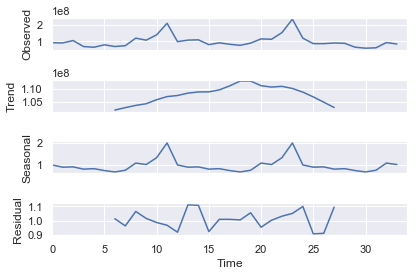

In [136]:
# multiplicative
res = sm.tsa.seasonal_decompose(monthly_sales_total_df.values,freq=12,model="multiplicative")
fig = res.plot()

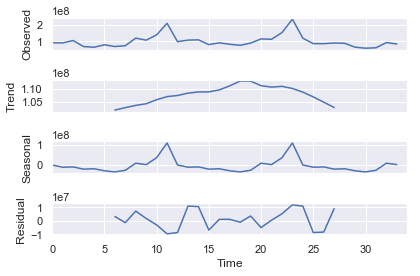

In [137]:
# additive
res = sm.tsa.seasonal_decompose(monthly_sales_total_df.values,freq=12,model="additive")
fig = res.plot()